In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [82]:
ticker = 'MSFT'
df = yf.download(ticker, start='2020-01-01')

/var/folders/yv/vh7rldds4k9bqhgcldmc2h580000gn/T/ipykernel_70626/179016838.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start='2020-01-01')
[*********************100%***********************]  1 of 1 completed


In [83]:
df

Price,Close,High,Low,Open,Volume
Ticker,MSFT,MSFT,MSFT,MSFT,MSFT
Date,,,,,
2020-01-02,153.042297,153.147108,150.860341,151.289108,22622100
2020-01-03,151.136642,152.403898,150.603064,150.850807,21116200
2020-01-06,151.527313,151.594018,149.126197,149.669313,20813700
2020-01-07,150.145691,152.137085,149.897962,151.803606,21634100
2020-01-08,152.537338,153.213849,150.498299,151.432061,27746500
...,...,...,...,...,...
2025-06-20,477.399994,483.459991,476.869995,482.230011,37576200
2025-06-23,486.000000,487.750000,472.510010,478.209991,24864000


<Axes: xlabel='Date'>

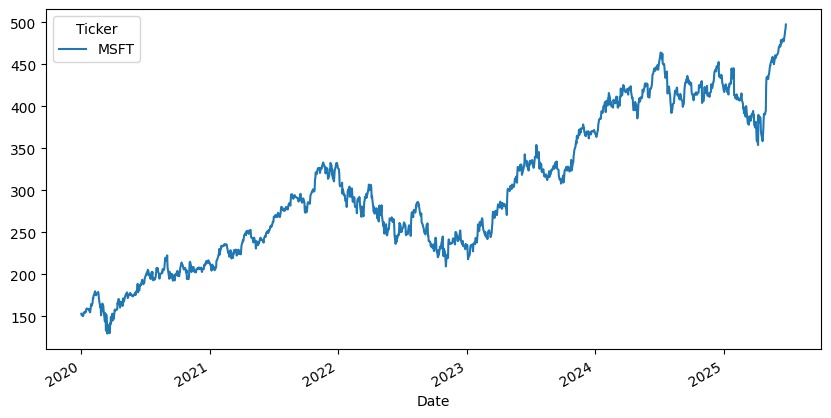

In [84]:
df.Close.plot(figsize=(10,5))

In [85]:
scaler = StandardScaler()

df["Close"] = scaler.fit_transform(df["Close"])

In [86]:
len(df)

1378

In [87]:
seq_length = 30
data = []

for i in range(len(df) - seq_length):
    # data.append(df[i:i+seq_length])
    data.append(df["Close"].values[i:i+seq_length])

data = np.array(data)
if data.ndim == 2:
    data = data.reshape((data.shape[0], data.shape[1], 1))

In [88]:
data

array([[[-1.68289552],
        [-1.70480357],
        [-1.70031229],
        ...,
        [-1.42197227],
        [-1.41901451],
        [-1.4299681 ]],

       [[-1.70480357],
        [-1.70031229],
        [-1.71619588],
        ...,
        [-1.41901451],
        [-1.4299681 ],
        [-1.4120042 ]],

       [[-1.70031229],
        [-1.71619588],
        [-1.6887007 ],
        ...,
        [-1.4299681 ],
        [-1.4120042 ],
        [-1.39141057]],

       ...,

       [[ 1.59222345],
        [ 1.71305775],
        [ 1.71168106],
        ...,
        [ 2.07867859],
        [ 2.04602904],
        [ 2.14489759]],

       [[ 1.71305775],
        [ 1.71168106],
        [ 1.75528664],
        ...,
        [ 2.04602904],
        [ 2.14489759],
        [ 2.19214735]],

       [[ 1.71168106],
        [ 1.75528664],
        [ 1.76701313],
        ...,
        [ 2.14489759],
        [ 2.19214735],
        [ 2.21697948]]])

In [89]:
# train_size = int(0.8 * len(data))

# X_train = torch.from_numpy(data[:train_size, :-1, :]).type(torch.FloatTensor).to(device)
# y_train = torch.from_numpy(data[:train_size, -1, :]).type(torch.FloatTensor).to(device)

# X_test = torch.from_numpy(data[train_size:, :-1, :]).type(torch.FloatTensor).to(device)
# y_test = torch.from_numpy(data[train_size:, -1, :]).type(torch.FloatTensor).to(device)

# Train-test split
train_size = int(0.8 * len(data))
X_train = torch.from_numpy(data[:train_size, :-1, :]).float().to(device)
y_train = torch.from_numpy(data[:train_size, -1, :]).float().to(device)
X_test = torch.from_numpy(data[train_size:, :-1, :]).float().to(device)
y_test = torch.from_numpy(data[train_size:, -1, :]).float().to(device)

In [90]:
class PredictionModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(PredictionModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, device=device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, device=device)

        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

In [91]:
# model = PredictionModel(input_size=5, hidden_size=32, num_layers=2, output_size=1).to(device)
model = PredictionModel(input_size=1, hidden_size=32, num_layers=2, output_size=1).to(device)


In [92]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [93]:
num_epochs = 200

for i in range(num_epochs):
    y_train_pred = model(X_train)
    loss = criterion(y_train_pred, y_train)

    if i % 25 == 0:
        print(f'Epoch {i}, loss: {loss}')
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch 0, loss: 0.6343985795974731
Epoch 25, loss: 0.012741640210151672
Epoch 50, loss: 0.005052771419286728
Epoch 75, loss: 0.004406822845339775
Epoch 100, loss: 0.004085845313966274
Epoch 125, loss: 0.003863444784656167
Epoch 150, loss: 0.0036793553736060858
Epoch 175, loss: 0.003521400736644864


In [94]:
model.eval()

# Get predictions from model
y_train_pred_tensor = model(X_train)
y_test_pred_tensor = model(X_test)

# Convert predictions to numpy
y_train_pred = y_train_pred_tensor.detach().cpu().numpy()
y_test_pred = y_test_pred_tensor.detach().cpu().numpy()

# y_train and y_test are already numpy, so no need for detach()
y_train_true = y_train  # Already numpy
y_test_true = y_test    # Already numpy

# Inverse transform everything
y_train_pred = scaler.inverse_transform(y_train_pred)
y_test_pred = scaler.inverse_transform(y_test_pred)
y_train = scaler.inverse_transform(y_train_true)
y_test = scaler.inverse_transform(y_test_true)



In [95]:
train_rmse = root_mean_squared_error(y_train[:, 0], y_train_pred[:, 0])
test_rmse = root_mean_squared_error(y_test[:, 0], y_test_pred[:, 0])

In [96]:
train_rmse

np.float64(5.062264775918986)

In [97]:
test_rmse

np.float64(9.077019736063786)

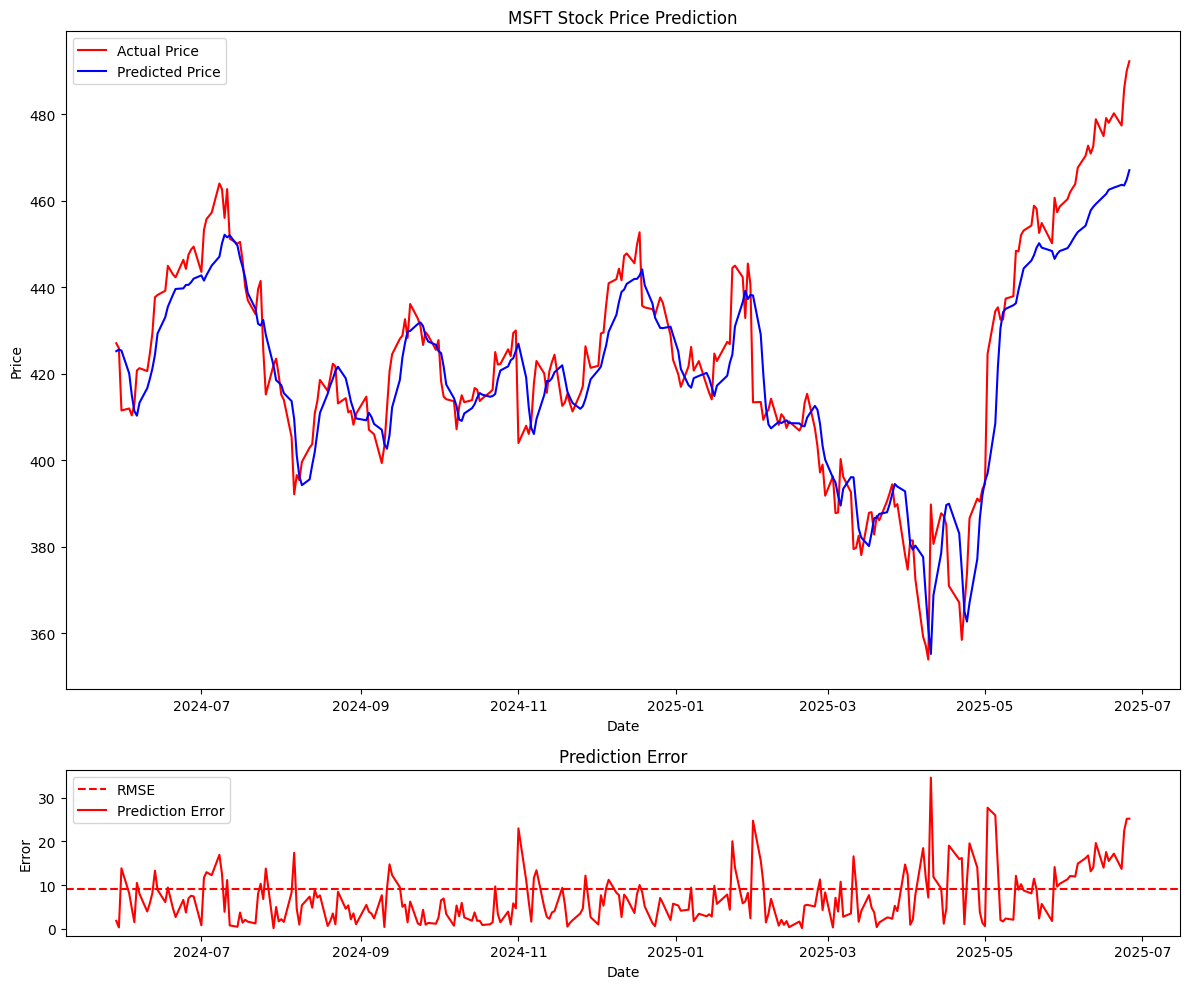

In [98]:
fig = plt.figure(figsize=(12, 10))

gs = fig.add_gridspec(4,1)
ax1 = fig.add_subplot(gs[:3,0])
ax1.plot(df.iloc[-len(y_test):].index, y_test, color='red', label='Actual Price')
ax1.plot(df.iloc[-len(y_test):].index, y_test_pred, color='blue', label='Predicted Price')
ax1.legend()
plt.title(f'{ticker} Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')

ax2 = fig.add_subplot(gs[3,0])
ax2.axhline(test_rmse, color='red', linestyle='--', label='RMSE')
ax2.plot(df.iloc[-len(y_test):].index, abs(y_test_pred - y_test), "r", label='Prediction Error')
ax2.legend()
plt.title("Prediction Error")
plt.xlabel('Date')
plt.ylabel('Error')
plt.tight_layout()
plt.show()